# DeepJazzLyrics - Intro

The five (or five of the) ["best Jazz singers of all time"](https://www.udiscovermusic.com/stories/50-best-jazz-singers/) are Ella Fitzgerald, Frank Sinatra, Nat King Cole, Billie Holiday and Sarah Vaughan. Together, these singers cover most of the songs that today are considered to be [Jazz Standards](https://en.wikipedia.org/wiki/Jazz_standard). 

Jazz Standards are performed and re-interpreted by both amateur and professional musicians around the world. Take, for example, the song "autumn leaves". There are millions of versions of this song, including rather [traditional version from Frank Sinatra](https://youtu.be/AO-H9Ni5NiQ?t=40), [Sarah Vaughn  scatting](https://youtu.be/5cZG2WnXPgk?t=40) on the chords, an instrumental interpretation by the [famous guitar player Joe Pass](https://youtu.be/795sG19cPmU) and again a more traditional version by the contemporary artist [Eric Clapton](https://youtu.be/UQlFOX0YKlQ). 

Looking at all of the artists songs can be considered representative for the 20th century jazz. The goal of this notebook is to analyse the lyrics of these jazz singers. First we will look at some clustering and topic modelling approaches of the songs. Then the goal is to create a generative model that outputs a jazz song in their style. Future plans include creating a model for the song chords (leadsheet) aswell.

In [0]:
# Execute after restarting runtime
!git clone https://github.com/alxwdm/jazzlyrics

In [0]:
# Execute when content on github changed
%cd /content/jazzlyrics/
!git pull
%cd /content/

In [0]:
""" Setup """

from google.colab import drive
drive.mount('/content/drive')

# General
import numpy as np
import pandas as pd

# TensorFlow
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#import pyLDAvis
#import pyLDAvis.gensim

# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix

# Custom classes
import sys
sys.path.append('/content/jazzlyrics')
from LyricsCrawler import LyricsCrawler
from TopicModeller import TopicModeller

print('---- setup complete. ----')

# Data Loading and Clearing


## Get Lyrics via Genius API

Inspired by [github/jasonqng](https://github.com/jasonqng/genius-lyrics-search) and [github/kvsingh](https://github.com/kvsingh/lyrics-sentiment-analysis).

In [0]:
# Get Top 5 Jazz Artist Lyrics
# !Searching and extracting the lyrics may take up to 1h for the five artists!

token = 'your_token_here'
artists = ['Frank Sinatra', 'Ella Fitzgerald', 'Nat King Cole', 'Billie Holiday', 'Sarah Vaughan']

lyrics = LyricsCrawler(token, artists)
lyrics.save('JazzLyrics')

df = lyrics.get_df()
df.head(10)

## Load JazzLyrics and Clear Data

In [3]:
df = pd.read_excel('JazzLyrics.xlsx') # must upload data manually to colab!
df.head(5)

,Artist,Title,url,lyrics
0,Frank Sinatra,Fly Me to the Moon,https://genius.com/Frank-sinatra-fly-me-to-the...,\n\n[Verse 1]\nFly me to the moon\nLet me play...
1,Frank Sinatra,My Way,https://genius.com/Frank-sinatra-my-way-lyrics,"\n\n[Verse 1]\nAnd now, the end is near\nAnd s..."
2,Frank Sinatra,The Way You Look Tonight,https://genius.com/Frank-sinatra-the-way-you-l...,"\n\nSome day, when I'm awfully low\nWhen the w..."
3,Frank Sinatra,Somethin’ Stupid,https://genius.com/Frank-sinatra-somethin-stup...,\n\n[Vocals: Frank Sinatra & Nancy Sinatra]\n\...
4,Frank Sinatra,The Girl from Ipanema,https://genius.com/Frank-sinatra-the-girl-from...,\n\n[Frank Sinatra]\nTall and tan and young an...


In [4]:
# In Jazz it's common to cover songs ("Jazz Standards").
# The covered versions may vary a lot, but the text usually stays the same.
# Duplicate Titles should therefore be dropped.

print('Total Titles:  ', len(df['Title']))
print('Unique Titles: ', len(df['Title'].unique()))

df.drop_duplicates(subset='Title', inplace=True)
print('---------')
print('Titles after dropping:  ', len(df['Title']))

Total Titles:   2856
Unique Titles:  2424
---------
Titles after dropping:   2424


In [5]:
# Remove song structures in brakets and triple newlines.

# Remove song structures like [Verse 1] etc.
regex = r'\[.+\](?!=[\n]{1})' # remove []
df['lyrics'] = df['lyrics'].str.replace(regex,'',regex=True)
regex = r'\(.+\)(?!=[\n]{1})' # remove ()
df['lyrics'] = df['lyrics'].str.replace(regex,'',regex=True)
regex = r'\{.+\}(?!=[\n]{1})' # remove {}
df['lyrics'] = df['lyrics'].str.replace(regex,'',regex=True)
regex = r'\[.+\}(?!=[\n]{1})' # one entry with a typo
df['lyrics'] = df['lyrics'].str.replace(regex,'',regex=True)

# remove triple newlines
regex = r'[\n]{3,}' 
df['lyrics'] = df['lyrics'].str.replace(regex,'\n\n',regex=True)

# Test if clearing was succesfull
print('No []  remaining: ', df[df['lyrics'].str.contains('\[')==True].empty)
print('No {}  remaining: ', df[df['lyrics'].str.contains('\{')==True].empty)
print('No ()  remaining: ', df[df['lyrics'].str.contains('\(')==True].empty)
print('No 3\\n remaining: ', df[df['lyrics'].str.contains('\n\n\n')==True].empty)

# The remaining ()-brakets are part of the lyrics and should be kept!

No []  remaining:  True
No {}  remaining:  True
No ()  remaining:  False
No 3\n remaining:  True


In [6]:
# Check for NaNs and drop them.

print('NaN value count (before dropping): ', df['lyrics'].isna().sum())
df.dropna(inplace=True)
print('NaN value count (after dropping):  ', df['lyrics'].isna().sum())

NaN value count (before dropping):  1
NaN value count (after dropping):   0


# Analysis of the Jazz Lyrics

Analyizing song texts is part of a field of study called Music Information Retrieval (MIR). MIR yields an enormous business potential for the music industry, for example in developing sophisticated recommender systems for streaming services. The "International Society for Music Information Retrieval" ([ISMIR](https://ismir.net/)) is hosting annual conferences on this topic.

Most of the publicly available releases of lyric analysis deal with a large number of songs throughout different genres, e.g. using the [Million Song Dataset](http://millionsongdataset.com/). Also, there is research regarding the addition of labelled examples and using supervised learning methods for music classification. However, my "self-crawled" dataset is genre-specific, fairly small and unlabelled so I guess analyising it will be quite difficult. 

I try to pursue the following analysis ideas:
* Manually analyse the most frequent topic: love.
* (Unsupervised) topic modelling using LDA.
* Clustering songs with document similarity.
* Sentiment analysis (happy/sad), maybe using a pre-trained model.

## Is Jazz all about love?

The obviously most frequent topic in jazz songs is love. If this really is the dominating topic, then any clustering attempts on topics of the jazz lyrics dataset could be difficult. Therefore, I'll carry out a manual analysis of the love topic first. 

To do so, I'll check how many songs explicitly contain the word "love" in any form and tag them. Of course, love can also be expressed implicitly with words such as "kiss" and "heart" and so on. But as a best guess, this leads to the most accurate results (heart for example could describe sentiments in general) and leaves room for machine-learning approaches for topic modelling of the "not so straightforward" categories.

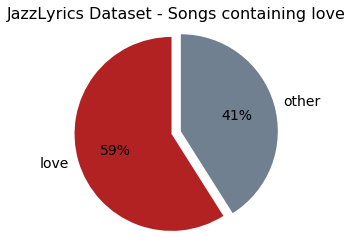

In [0]:
# How many songs are love songs?

# For topic modelling, create a new column with categorical encoding.
# The topic_dict will be updated with each new topic to be found.

df['topic'] = 0
topic_dict = {0: 'tbd'}

# choose love words
love_words = ['love']
# PorterStemmer is used for stemming
porter = nltk.PorterStemmer()
# stemm love_words
love_words = [porter.stem(t) for t in love_words]

love_count = 0
total_count = int(len(df['lyrics']))

# iterate over df
for idx, string in df['lyrics'].iteritems():
  # tokenize and stem the lyrics
  tokens = nltk.word_tokenize(string)
  stemmed = [porter.stem(t) for t in tokens]
  # check if the lyrics contain a "love word"
  for love_word in love_words:
    if any(love_word in s for s in stemmed):
      # increase love counter
      love_count = love_count+1
      # update topic
      df.at[idx, 'topic'] = 1
      break

# update topic dictionary
topic_dict[1] = 'love'

# Create pie chart
labels = ['love', 'other']
sizes = [love_count, total_count-love_count]
colors = ['firebrick', 'slategrey']
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        colors=colors, shadow=False, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  
ax1.set_title('JazzLyrics Dataset - Songs containing love', fontsize= 16)
plt.show()

## Topic Modelling with LDA

Now using a machine-learning approach, the lyrics are count-vectorized ignoring english stop words as well as uncommon (min_df - percentage or absolute count) and very common (max_df - percentage or absolute count) words. The resultig sparse matrix is then converted to a gensim corpus. For topic modelling, a Latent Dirichlet Allocation (LDA) is trained. This algorithm uses a statistical model to find relevant topic-words and get the topic distribution of a given document (meaning it assumes that a document contains multiple topics). The LDA is evaluated using the coherence score to get the optimal number of topics. The most indicative words for each topic are extracted to label the topic.

In [0]:
# Hyperparameters for topic modelling
lda_config = {
'n_topics': 4,         # how many topics
'n_passes': 25,        # how many passes for modelling
'min_docfreq': 25,     # minimum document frequency to include in vectorizer
'max_docfreq': 0.7,    # maximum document frequency to include in vectorizer
'ngrams': (1,2),       # n-gram range, e.g. (1,1) means only single words
'n_words': 5,          # how many topic-related words are displayed
'topic_range': (2,20), # topic range for optimizing number of topics
'ext_stop_words': ['just', 'like', 'know'], # additional custom stop words
}

Ideally, the coherence converges with increasing number of topics. Then, the optimum is chosen at the smallest number of topics where the coherence is still close to the converged value. However, it is application specific, so still a smaller or larger number of topics can be chosen. The overall goal is to get topics that are as distinct as possible with topic-indicative words as interpretable as possible. 

Running optimization with topic range from 2 to 20
Bag-of-Words shape:  (2423, 605)
Optimization completed, plotting results...


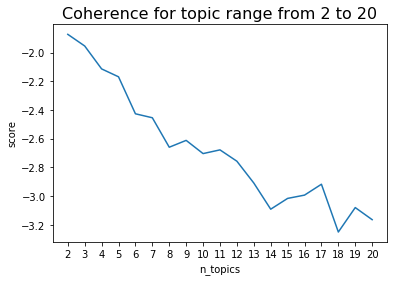

In [0]:
# Let's optimize LDA with all lyrics
topicmodel = TopicModeller(lda_config, df['lyrics'])
topicmodel.optimize()

In [0]:
# Let's try 4 topics:
topicmodel = TopicModeller(lda_config, df['lyrics'])
new_config = lda_config.copy()
new_config['n_topics'] = 4
topicmodel.update(new_config) 
topicmodel.run()
_, topic_matrix, _ = topicmodel.get_lda()

topic_matrix

Bag-of-Words shape:  (2423, 605)


[(0,
  '0.152*"love" + 0.031*"heart" + 0.017*"never" + 0.015*"care" + 0.015*"love love"'),
 (1,
  '0.035*"dream" + 0.023*"night" + 0.020*"heart" + 0.017*"kiss" + 0.017*"love"'),
 (2,
  '0.035*"babi" + 0.034*"make" + 0.026*"good" + 0.023*"look" + 0.017*"time"'),
 (3,
  '0.037*"come" + 0.030*"blue" + 0.021*"littl" + 0.020*"sing" + 0.016*"back"')]

Given the small and poetic dataset, I'll stick with 4 categories even though the coherence is far from convergecnce. The topics found by the LDA can be categorized as follows:

0: Everything about love!

1: Also a love topic, but more focused on wishes and dreams. Maybe dreaming about love?

2: Songs about women (which might also be love songs but don't explicitly contain words like "love", "kiss", etc.).

3: Everything else, like feelings in general, singing, longing.

Now it would be interessting to compare the manually categorized love songs with the topics proposed by LDA. As the LDA assumes that a document contains multiple topics and therefore outputs a topic distribution, I'll use the most-relevant topic for labelling.


F1-Score: 0.74


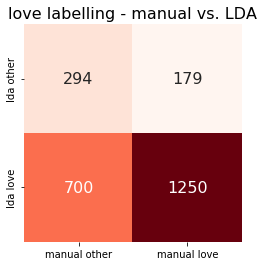

In [0]:
# LDA Analysis
# Compare manually labelled love songs vs. love topics from LDA.

# Add ldatopics to df.
df['ldatopic'] = topicmodel.label()

# Define love topics
df['lda_islove'] = df['ldatopic'].apply(lambda x: x==0 or x==1 or x==2).astype(int)

# Compare results
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(df['lda_islove'], df['topic'])
tn, fp, fn, tp = conf_matrix.ravel() 
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('F1-Score: {0:.2f}'.format(2*(precision*recall/(precision+recall))))

fig, ax = plt.subplots()
ax=sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, 
            cbar=False, square=True, fmt='g', cmap='Reds',
            xticklabels = ['manual other', 'manual love'], 
            yticklabels = ['lda other', 'lda love'])
ax.set_title('love labelling - manual vs. LDA', fontsize=16)
plt.yticks((0.5,1.5),('lda other', 'lda love'), va='center');

The comparison leads to an F1-Score of 0.74. As we can see in the confusion matrix, the LDA assigns a different "most-relevant" topic for only 179 manually labelled love songs which is about 7% of all songs. However, LDA categorizes 700 more songs as love songs (although category 2, the "songs about women", are not necessarily all love songs so this category is not distinct enough). 

Because of the large true positives of the manually labelled love songs, I decide to keep the manually assigned label and train the LDA only on the "other" songs to find more distinct categories. It turns out that this is actually the case.





In [0]:
df_other = df.where(df['topic']==0).dropna()
topicmodel_other = TopicModeller(lda_config, df_other['lyrics'])
new_config = lda_config.copy()
new_config['min_docfreq'] = 10
new_config['n_topics'] = 4
topicmodel_other.update(new_config)
topicmodel_other.run()
_, topic_matrix, _ = topicmodel_other.get_lda()

topic_matrix

Bag-of-Words shape:  (994, 679)


[(0,
  '0.022*"babi" + 0.022*"good" + 0.017*"kiss" + 0.014*"right" + 0.014*"tell"'),
 (1,
  '0.022*"time" + 0.019*"come" + 0.018*"heart" + 0.017*"never" + 0.015*"long"'),
 (2,
  '0.037*"dream" + 0.018*"come" + 0.016*"star" + 0.015*"night" + 0.015*"could"'),
 (3,
  '0.029*"blue" + 0.024*"make" + 0.021*"song" + 0.020*"come" + 0.019*"swing"')]

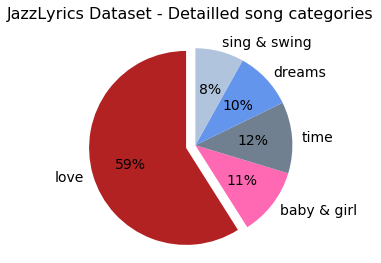

In [0]:
# get labels and add +2 to categorical value (0: tbd, 1: love)
df_other['ldatopic'] = [x+2 for x in topicmodel_other.label()]
topic_dict[2] = 'baby'
topic_dict[3] = 'time'
topic_dict[4] = 'dreams'
topic_dict[5] = 'sing & swing'

# Add to "root" df
df['topic'].update(df_other['ldatopic'])
df.head(10)

# Pie-Plot
labels = ['love', 'baby & girl', 'time', 'dreams', 'sing & swing']
love_count = len(df['topic'].where(df['topic'] == 1).dropna())
baby_count = len(df['topic'].where(df['topic'] == 2).dropna())
time_count = len(df['topic'].where(df['topic'] == 3).dropna())
drms_count = len(df['topic'].where(df['topic'] == 4).dropna())
sing_count = len(df['topic'].where(df['topic'] == 5).dropna())
sizes = [love_count, baby_count, time_count, drms_count, sing_count]
colors = ['firebrick', 'hotpink', 'slategrey', 'cornflowerblue', 'lightsteelblue']
explode = (0.1, 0, 0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        colors=colors, shadow=False, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  
ax1.set_title('JazzLyrics Dataset - Detailled song categories', fontsize= 16, pad=20)
plt.show()

In [0]:
# Print examples for each category

love_df = df['Title'].where(df['topic'] == 1).dropna().sample(5, random_state=93)
baby_df = df['Title'].where(df['topic'] == 2).dropna().sample(5, random_state=60)
time_df = df['Title'].where(df['topic'] == 3).dropna().sample(5, random_state=18)
drms_df = df['Title'].where(df['topic'] == 4).dropna().sample(5, random_state=90)
sing_df = df['Title'].where(df['topic'] == 5).dropna().sample(5, random_state=15)

frame = {'Love': love_df.values, 
         'Baby': baby_df.values, 
         'Time': time_df.values,
         'Dreams': drms_df.values,
         'Sing & Swing': sing_df.values}
pd.DataFrame(frame)

,Love,Baby,Time,Dreams,Sing & Swing
0,I Wonder Who’s Kissing Her Now,My Baby Just Cares For Me,The Summer Knows,Perdido,Get Your Kicks On Route 66
1,Fly Me to the Moon,What a Funny Girl (You Used to Be),"Sunday, Monday or Always",Dreamy,Back in My Arms
2,Tenderly,I’m Sorry I Made You Cry,Spring Will Be A Little Late This Year,The Nearness Of You,Brahm’s Lullaby
3,Remind Me,Solamente una Vez,I’m Gonna Live ’Til I Die,What Shall I Say?,I Get a Kick Out of You (Cinematic Orchestra r...
4,So In Love,I’m Scared,Don’t Dream Of Anybody But Me,I Could Have Danced All Night,"Sing, Song, Swing"


Printing out some examples of the song titles of the respective categories, we can see that the classification is actually quite good, though it is of course far from perfect. As already mentioned, this is due to the short, very poetic (and therefore ambiguous) lyrics in Jazz, and also because of the relatively small dataset.

Positive examples from the "Love" category are all-time favourite love songs like "Fly me to the Moon" by Frank Sinatra, "Tenderly" by Ella Fitzgerald and "So In Love". The "Baby/Girls" category contains "My Baby Just Cares For Me" and "What a Funny Girl". In the "Time" category there are songs like "The Summer Knows", "Sunday, Monday or Always" and "Spring Will Be A Little Late This Year". Dreams contains "Perdido", a song about memories of a farewell, "Dreamy" and "I Could Have Danced All Night". Finally, Sing & Swing contains the perfectly matching song "Sing, Song, Swing". 


# Generative Lyrics Model

**In Progress!** The goal is to implement a generative model that outputs lyrics for a jazz song, then write some chords and record it! :)

To do so, the first question is whether to implement the generative model on a character level basis or on words. Andrej Karpathy has achieved fun results with character level language models in [his blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) on poems, wikipedia entries and even Linux source code. However, for the Shakespeare LSTM the corpus is fairly large (all of Shakespeare's work!) and training has taken a few hours. I don't want to spend too much training time to teach my model how to speak english, so I'll go for a word based approach first and see how the model performs.

For reference, here's also a link to a character level language model from the [keras team](https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py).

In [0]:
# Hyperparameters for lyrics generation with LSTM
"""
All hyperparameters for generative model of song lyrics will be set here.
config dict will be updated as work progresses.
"""
lyrics_config = {
'mini_batch_len': 10,            # length of window size for mini batches
'mini_batch_step': 2             # step size (dilation) for mini batch creation
}

In [0]:
# LyricsGenerator Class 
# work in progress, will be put into separate file once it's finished.

from nltk.tokenize import word_tokenize

class LyricsGenerator:
  """
  (work in progress)
  This class is used for training a generative model that outputs Jazz lyrics.
  """

  def __init__(self, config, corpus):
    self.raw = corpus
    self.mini_batch_len = config['mini_batch_len']
    self.mini_batch_step = config['mini_batch_step']
    return


  def _preproc(self):
    """
    This function preprocesses the input corpus:
      * tokenizes the input corpus
      * creates word-id-maps
      * vectorizes the input corpus
    """
    # Tokenize corpus using nltk tokenizer
    corpus = self.raw.apply(word_tokenize)

    # Lowercase corpus and get individual words
    for idx, s in corpus.iteritems():
      corpus[idx] = [s.lower() for s in corpus[idx]]

    # Get unique words from corpus
    words = [[s for s in corpus[idx]]]
    for idx, s in corpus.iteritems():
      words.append([s for s in corpus[idx]])
    words = [word for s in words for word in s]
    unique_words = sorted(list(set(words)))
    print('Total Word count:  ', len(words))
    print('Unique word count: ', len(unique_words))

    # Create word <-> id maps
    self.word_id = dict((c, i) for i, c in enumerate(unique_words))
    self.id_word = dict((i, c) for i, c in enumerate(unique_words))

    # Vectorize corpus
    self.tok_corpus = []
    for idx, s in corpus.iteritems():
      document = [word for word in corpus[idx]]
      tok_doc = [self.word_id[word] for word in document]
      self.tok_corpus.append(tok_doc)

    return self.word_id, self.id_word, self.tok_corpus


  def _generateBatches(self):
    """
    This function generates batches that can be used for training.
      * Batches are in shape (m, T, n), where each sample is zero-padded
        to the maximum song length. 
      * Creates X and Y data. 
      * Also creates sample weights, with zero-padded parts having zero weight.
    """
    # Get longest sample
    longest_song = max(tok_corpus,key=len)
    max_len = len(longest_song)
    print('Maximum song length is', max_len, 'words.')

    # Create X and weights array
    self.X = []
    self.weights = []
    for song in tok_corpus:
      # Get zero-padded array for each song
      arr = np.asarray(song)
      _arr = np.zeros(max_len - np.size(arr))
      sample = [np.concatenate((arr, _arr))]
      self.X.append(sample)
      # Get sample weights (zero padded sequence = zero weight)
      sample_weight = [np.concatenate((np.ones(arr.shape), np.zeros(_arr.shape)), axis=0)]
      self.weights.append(sample_weight)

    # Create X and weights array
    self.X = np.swapaxes(np.asarray(self.X),1,2)
    self.weights = np.swapaxes(np.asarray(self.weights),1,2)

    # Create Y array (TODO: Change '!' symbol to new line as last token)
    self.Y = np.asarray([np.append(x[1:], word_id['!']) for x in self.X])

    # Reshape dimensions
    self.Y = np.expand_dims(self.Y, axis=2)
    self.weights = self.weights[:,:,0]

    # Print output shapes
    print('Shape of X:       ', self.X.shape)
    print('Shape of Y:       ', self.Y.shape)
    print('Shape of weights: ', self.weights.shape)

    return 


  def _generateMiniBatches(self):
    """
    This function generates semi-redundant mini batches that can be used 
    for training.
      * The shape is (m, T_mini, n) where T_mini is the window size.
      * Mini-batches are dilated with given step size.
    """

    # Init array
    self.X_mini = []

    # iterate over tokenized corpus
    for song in tok_corpus:
      # iterate over one song from tokenized corpus
      for i in range(0, len(song) - self.mini_batch_len, self.mini_batch_step):
        self.X_mini.append(song[i: i + self.mini_batch_len])

    # Create X and Y array in correct shape
    self.X_mini = np.asarray(self.X_mini)
    self.X_mini = np.expand_dims(self.X_mini, axis=2)
    self.Y_mini = np.asarray([np.append(x[1:], word_id['!']) for x in self.X_mini])
    self.Y_mini = np.expand_dims(self.Y_mini, axis=2)

    # Print output shapes
    print('Shape of X_mini:  ', self.X_mini.shape)
    print('Shape of Y_mini:  ', self.Y_mini.shape)

    return 

In [0]:
# Create LyricsGenerator instance
lyricsgen = LyricsGenerator(lyrics_config, df['lyrics'])